In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import preprocessing 
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.feature_selection import SelectFromModel

In [4]:
#读取数据
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv('test.csv')
all_data = pd.concat([train_data, test_data])
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
train_data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

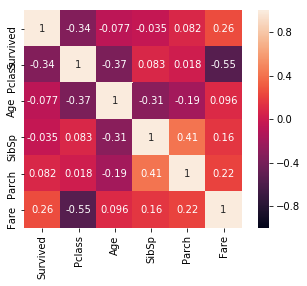

In [6]:
train_corr = train_data.drop('PassengerId',axis=1).corr()
sns.heatmap(train_corr, vmin=-1, vmax=1 , annot=True , square=True)#画热力图

In [7]:
train_data['Title'] = train_data['Name'].str.extract('.+,(.+)', expand=False).str.extract('^(.+?)\.', expand=False).str.strip()
train_data['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer' , inplace = True)
train_data['Title'].replace(['Jonkheer', 'Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty' , inplace = True)
train_data['Title'].replace(['Mme', 'Ms', 'Mrs'], 'Mrs')
train_data['Title'].replace(['Mlle', 'Miss'], 'Miss')
train_data['Title'].replace(['Mr'], 'Mr' , inplace = True)
train_data['Title'].replace(['Master'], 'Master' , inplace = True)

#计算亲属个数
train_data['Family'] = train_data['Parch'] + train_data['SibSp']

#在1到3范围内存活率最高赋值2 大于6存活率最低赋值0
train_data['FamilyFinal'] = train_data['Family'].apply(lambda x: 0 if x > 6 else (2 if x >=1 and x <=3 else 1))

#对Cabin进行处理,提取首字母
train_data['Cabin'] = train_data['Cabin'].apply(lambda x:str(x)[0] if pd.notnull(x) else 'U')

#新增TicketGroup特征，统计每个乘客的共票号数。
Ticket_Count = dict(all_data['Ticket'].value_counts())
train_data['TicketGroup'] = train_data['Ticket'].apply(lambda x:Ticket_Count[x])
#同Family
train_data['TicketSize'] = train_data['TicketGroup'].apply(lambda x: 0 if x > 8 else (2 if x >=2 and x <=4 else 1))

#年龄分块
train_data['Ages'] = train_data['Age'].apply(lambda x: (x//4 * 4))

#票价分块
train_data['Fares'] = train_data['Fare'].apply(lambda x: (x//15 * 15))

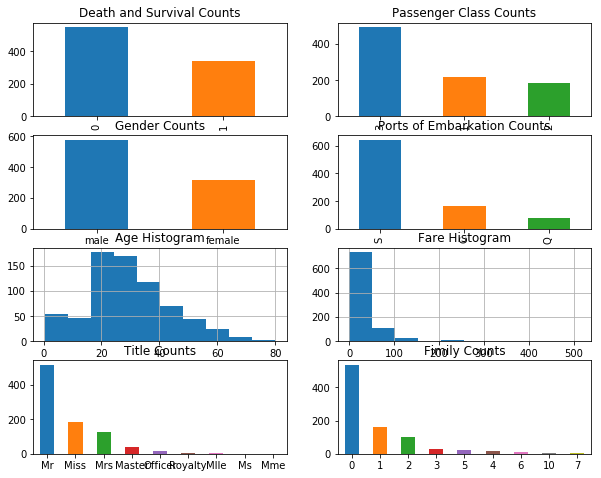

In [8]:

plt.rc('figure', figsize=(10, 5))
fizsize_with_subplots = (10, 10)
bin_size = 10
fig = plt.figure(figsize=fizsize_with_subplots) 
fig_dims = (5, 2)
plt.subplot2grid(fig_dims, (0, 0))
train_data['Survived'].value_counts().plot(kind='bar', 
                                         title='Death and Survival Counts')
plt.subplot2grid(fig_dims, (0, 1))
train_data['Pclass'].value_counts().plot(kind='bar', 
                                       title='Passenger Class Counts')
plt.subplot2grid(fig_dims, (1, 0))
train_data['Sex'].value_counts().plot(kind='bar', 
                                    title='Gender Counts')
plt.xticks(rotation=0)
plt.subplot2grid(fig_dims, (1, 1))
train_data['Embarked'].value_counts().plot(kind='bar', 
                                         title='Ports of Embarkation Counts')
plt.subplot2grid(fig_dims, (2, 0))
train_data['Age'].hist()
plt.title('Age Histogram')
plt.subplot2grid(fig_dims, (2, 1))
train_data['Fare'].hist()
plt.title('Fare Histogram')
plt.subplot2grid(fig_dims, (3, 0))
train_data['Title'].value_counts().plot(kind='bar', 
                                         title='Title Counts')
plt.xticks(rotation=0)
plt.subplot2grid(fig_dims, (3, 1))
train_data['Family'].value_counts().plot(kind='bar', 
                                         title='Fimily Counts')
plt.xticks(rotation=0)
plt.show()

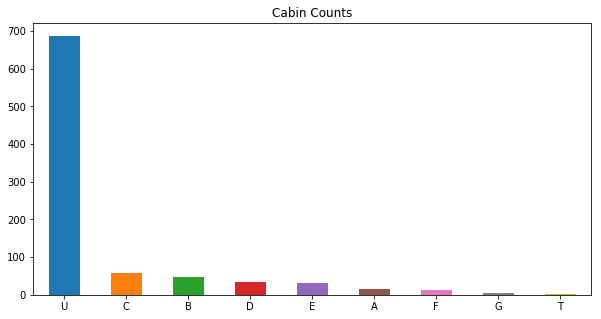

In [9]:
train_data['Cabin'].value_counts().plot(kind='bar', 
                                         title='Cabin Counts')
plt.xticks(rotation=0)
plt.show()

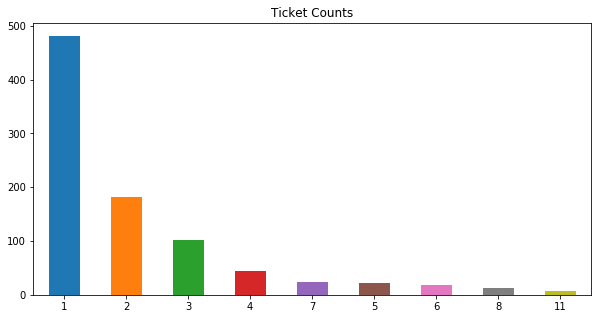

In [10]:
train_data['TicketGroup'].value_counts().plot(kind='bar', 
                                         title='Ticket Counts')
plt.xticks(rotation=0)
plt.show()

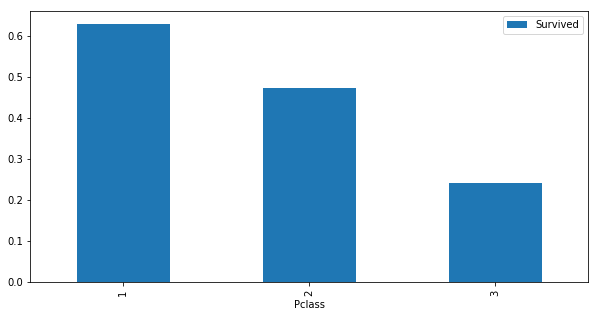

In [11]:
train_data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()

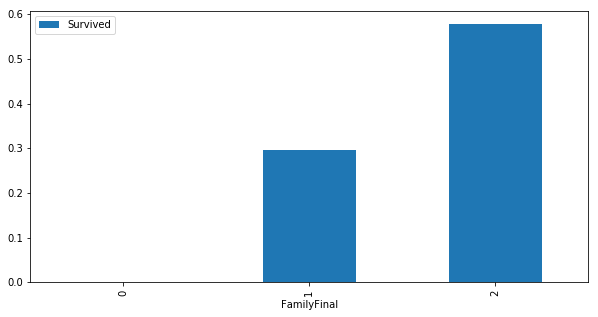

In [12]:
train_data[['FamilyFinal','Survived']].groupby(['FamilyFinal']).mean().plot.bar()

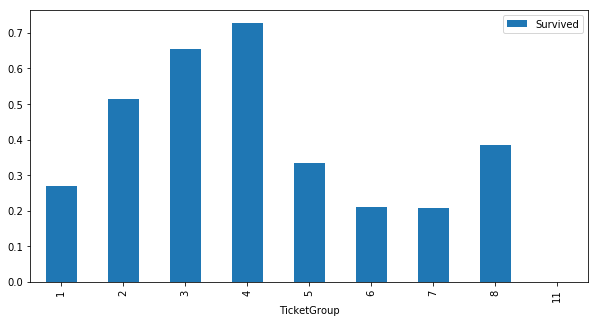

In [13]:
train_data[['TicketGroup','Survived']].groupby(['TicketGroup']).mean().plot.bar()

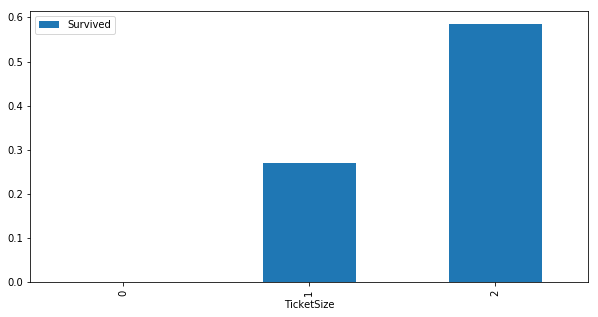

In [14]:
train_data[['TicketSize','Survived']].groupby(['TicketSize']).mean().plot.bar()

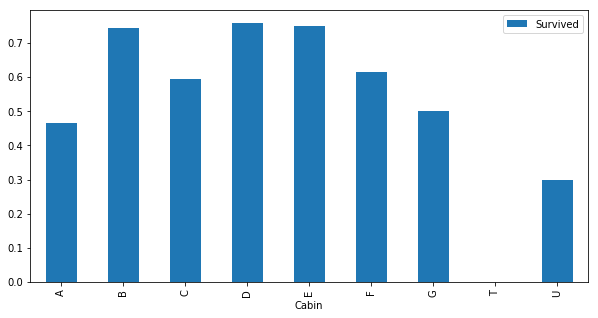

In [15]:
train_data[['Cabin','Survived']].groupby(['Cabin']).mean().plot.bar()

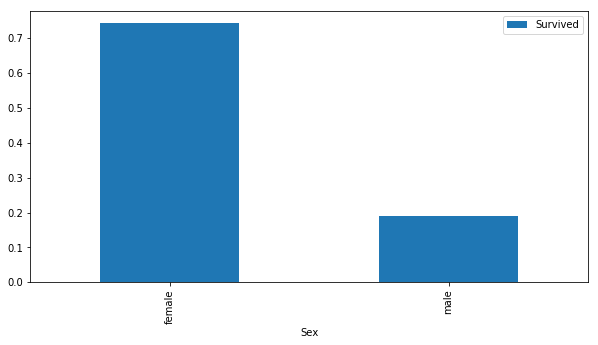

In [16]:
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

In [17]:
train_data[['Embarked','Survived']].groupby(['Embarked']).mean().plot.bar()

In [18]:
train_data[['Title','Survived']].groupby(['Title']).mean().plot.bar()

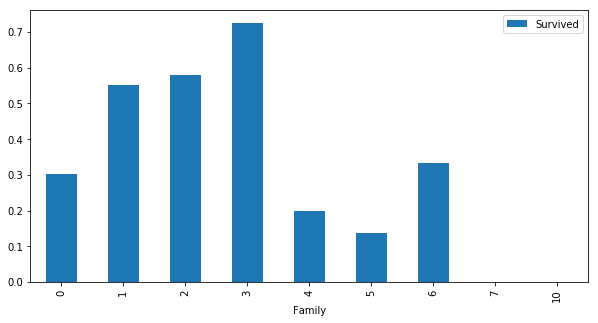

In [20]:
train_data[['Family','Survived']].groupby(['Family']).mean().plot.bar()

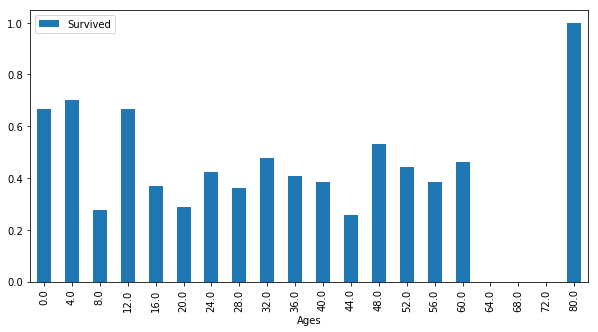

In [21]:
train_data[['Ages','Survived']].groupby(['Ages']).mean().plot.bar()

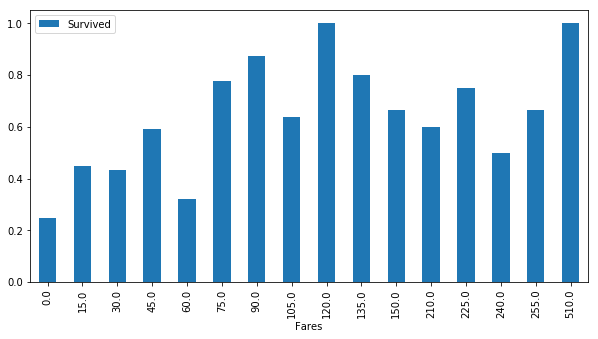

In [22]:
train_data[['Fares','Survived']].groupby(['Fares']).mean().plot.bar()